# Titanic ML competition

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## Overview

*(from https://www.kaggle.com/c/titanic/data)*

The data has been split into two groups:

* training set (`train.csv`)
* test set (`test.csv`)

The **training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The **test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include `gender_submission.csv`, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

## Data dictionary

*(from https://www.kaggle.com/c/titanic/data)*

| Variable | Definition | Key |
| :------- | :------- | :------- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| name | Passenger's name | Last name - Title - Name(s) - (Nick name) |
| sex | Sex |   |
| Age | Age in years|   |
| sibsp | # of siblings / spouses aboard the Titanic |   |
| parch | # of parents / children aboard the Titanic |   |
| ticket | Ticket number |   |
| fare | Passenger fare	 |   |
| cabin | Cabin number	 |   |
| embarked | Port of Embarkation	 | C = Cherbourg, Q = Queenstown, S = Southampton |

## Variable Notes

*(from https://www.kaggle.com/c/titanic/data)*

**pclass**: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
+ Sibling = brother, sister, stepbrother, stepsister
+ Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Getting into the challenge!

From a typical Scikit-Learn workflow, we're going to follow these steps:

0. Standard library imports
1. Get the data ready
2. Pick a model/estimator
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Submit predictions

### 0. Standard library imports

The most important libraries we'll going to use will be:

In [60]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Our Titanic case is a binary classification problem, ergo, will import some classification models for future testing:

> **Note:** as at 15/12/2021 CatBoost is not supported on Apple Silicon, where this notebook is being run, that's why it's commented for now. 

In [62]:
!pip install catboost
!pip install ipywidgets

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [63]:
# Import models from sklearn
import catboost
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

Lastly we'll need some extra tools for data manipulation from Scikit-Learn:

In [64]:
# Import aditional tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### 1. Get the data ready

This is a very important step because here we can certain treatments to the features in our data in order to take advantage on the processing in the following steps.

We'll import the data so as to start having a glimpse of it

In [65]:
# Import train and test csv from kaggle
!wget "https://raw.githubusercontent.com/markitos314/titanic_kaggle/main/train.csv"
!wget "https://raw.githubusercontent.com/markitos314/titanic_kaggle/main/test.csv"
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

--2021-12-15 15:36:27--  https://raw.githubusercontent.com/markitos314/titanic_kaggle/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  59.76K  --.-KB/s    in 0.01s   

2021-12-15 15:36:27 (4.89 MB/s) - ‘train.csv.1’ saved [61194/61194]

--2021-12-15 15:36:27--  https://raw.githubusercontent.com/markitos314/titanic_kaggle/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28629 (28K) [text/plain]
Saving to: ‘t

In [66]:
train.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

In [67]:
test.head()

PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]

As we can see, we have 12 columns in the training split and 11 in the test split (`Survived` is not there). We'll pay special atention to some of these so as to leverage as most as data as possible.

In [68]:
# Get a description of the train data
train.describe()

PassengerId    Survived      Pclass  ...       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642  ...    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071  ...    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000  ...    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000  ...    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000  ...    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000  ...    8.000000    6.000000  512.329200

[8 rows x 7 columns]

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [70]:
# Check NaN values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Some of our features are **numerical** (categorical or not), and some others are **strings**.

We'll analyse feature by feature.

#### 0. PassengerId

This one is not relevant, we'll drop this column.

In [71]:
X = train.drop("PassengerId", axis=1)
X.head(20)

Survived  Pclass  ... Cabin Embarked
0          0       3  ...   NaN        S
1          1       1  ...   C85        C
2          1       3  ...   NaN        S
3          1       1  ...  C123        S
4          0       3  ...   NaN        S
5          0       3  ...   NaN        Q
6          0       1  ...   E46        S
7          0       3  ...   NaN        S
8          1       3  ...   NaN        S
9          1       2  ...   NaN        C
10         1       3  ...    G6        S
11         1       1  ...  C103        S
12         0       3  ...   NaN        S
13         0       3  ...   NaN        S
14         0       3  ...   NaN        S
15         1       2  ...   NaN        S
16         0       3  ...   NaN        Q
17         1       2  ...   NaN        S
18         0       3  ...   NaN        S
19         1       3  ...   NaN        C

[20 rows x 11 columns]

#### 1. Survived

This column will be entirely the `y` set (labels or truth labels).

In [72]:
y = train["Survived"]
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

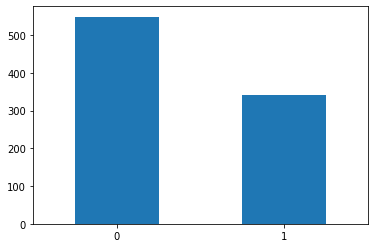

In [73]:
y.value_counts().plot.bar(rot=0);

#### 2. Pclass (Ticket class: 1st, 2nd or 3rd)

This feature is numerical, but still categorical. We'll need to one-hot-encode it, this means to split it into 3 columns each one representing a class, and just '1' or '0' if the passenger belongs (or doesn't) to that class.
Both Pandas and Scikit-Learn have one-hot-encoders, we'll use `get_dummies` from Pandas.

In [74]:
classes = pd.get_dummies(X.Pclass, prefix="Class")
classes

Class_1  Class_2  Class_3
0          0        0        1
1          1        0        0
2          0        0        1
3          1        0        0
4          0        0        1
..       ...      ...      ...
886        0        1        0
887        1        0        0
888        0        0        1
889        1        0        0
890        0        0        1

[891 rows x 3 columns]

In [75]:
classes.sum()

Class_1    216
Class_2    184
Class_3    491
dtype: int64

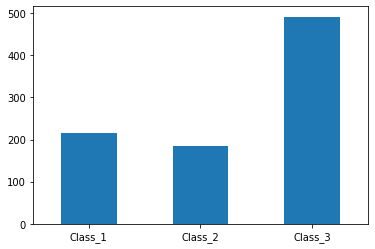

In [76]:
classes.sum().plot.bar(rot=0);

#### 3. Name

This feature seems not useful, but can be proccessed in order to be useful. If we pay atention, we have the `title` portion, from which we can leverage.

In [77]:
X.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

If we clean the surname, and all after the title we can have a useful feature. To split the complete name into elements, we access python's `str` method.

In [78]:
# Split words in name and make columns with the first and the rest of the split
name = X.Name.str.split(",", 0, expand=True)
# Drop the rest of the split
name.drop(0, axis=1, inplace=True)
name

1
0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
3             Mrs. Jacques Heath (Lily May Peel)
4                              Mr. William Henry
..                                           ...
886                                  Rev. Juozas
887                         Miss. Margaret Edith
888               Miss. Catherine Helen "Carrie"
889                              Mr. Karl Howell
890                                  Mr. Patrick

[891 rows x 1 columns]

In [79]:
name[1]

0                                  Mr. Owen Harris
1       Mrs. John Bradley (Florence Briggs Thayer)
2                                      Miss. Laina
3               Mrs. Jacques Heath (Lily May Peel)
4                                Mr. William Henry
                          ...                     
886                                    Rev. Juozas
887                           Miss. Margaret Edith
888                 Miss. Catherine Helen "Carrie"
889                                Mr. Karl Howell
890                                    Mr. Patrick
Name: 1, Length: 891, dtype: object

In [80]:
name = name[1].str.replace(" ", "").str.split(".").str[0]
name.value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
Sir              1
Lady             1
Don              1
Capt             1
Mme              1
Ms               1
theCountess      1
Jonkheer         1
Name: 1, dtype: int64

This way we have a name series to add to our features matrix. For now, we won't be able to use it, because we need to do the same treatment to the test set and this parsing may not be the same there. So we'll forget this.

#### 4. Sex

We need another one-hot-encoding for this one.

In [81]:
sex = pd.get_dummies(X.Sex)
sex.head()

female  male
0       0     1
1       1     0
2       1     0
3       1     0
4       0     1

In [82]:
sex.sum()

female    314
male      577
dtype: int64

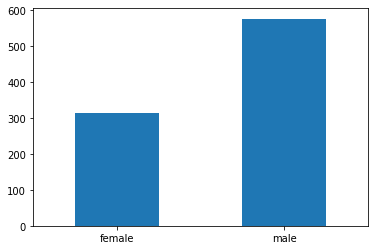

In [83]:
sex.sum().plot.bar(rot=0);

#### 5. Age

Age is a controversial one. It's a very important feature if we remember at that moment the famous "women and children first" phrase.
With this being said, let's remind ourselves the NaN situation with Age:

In [84]:
X.Age.isna().sum()

177

And the total lenght of the dataset was:

In [85]:
len(X), X.Age.isna().sum()/len(X)*100

(891, 19.865319865319865)

This means that we have missing values representing almost the 20% of the dataset. In these cases we can:
* Drop the column - loose the feature (technically called *Data Removal*)
* Fill the NaN values (technically called *Imputation*)

The second option has more options within.
Check out:
- https://www.mastersindatascience.org/learning/how-to-deal-with-missing-data/
- https://medium.com/@vinitasilaparasetty/guide-to-handling-missing-values-in-data-science-37d62edbfdc1

At this point we think there must be a correlation between the missing data on the **Age** feature and the **Pclass** value.

In [86]:
# Select only rows where Age = NaN
X[X["Age"].isna()]

Survived  Pclass  ... Cabin Embarked
5           0       3  ...   NaN        Q
17          1       2  ...   NaN        S
19          1       3  ...   NaN        C
26          0       3  ...   NaN        C
28          1       3  ...   NaN        Q
..        ...     ...  ...   ...      ...
859         0       3  ...   NaN        C
863         0       3  ...   NaN        S
868         0       3  ...   NaN        S
878         0       3  ...   NaN        S
888         0       3  ...   NaN        S

[177 rows x 11 columns]

In [87]:
# From this selection, get the total from each class
X[X["Age"].isna()].Pclass.value_counts()

3    136
1     30
2     11
Name: Pclass, dtype: int64

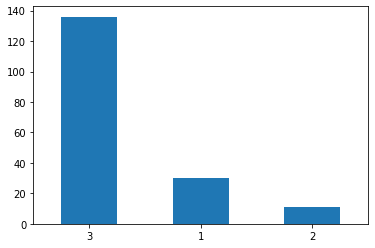

In [88]:
# Plot
X[X["Age"].isna()].Pclass.value_counts().plot.bar(rot=0);

So NaN values in age tend to be more common on people belonging to 3rd class.

Going back to *imputation* methods, there are a few, but we're going to try with the `median` value in all the dataset.

In [89]:
# Fill NaN values in Age column with median
X["Age"].fillna(X.Age.median(), inplace=True)

#### 6. SibSp

Reminder:
+ Sibling = brother, sister, stepbrother, stepsister
+ Spouse = husband, wife (mistresses and fiancés were ignored)

In [90]:
X.SibSp.describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

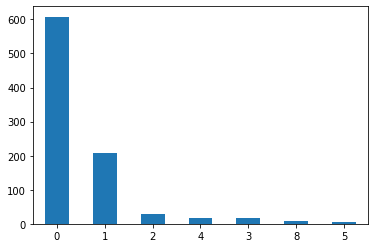

In [91]:
X.SibSp.value_counts().plot.bar(rot=0);

In [92]:
# Percentage of all dataset
X.SibSp.value_counts()/len(X)*100

0    68.237935
1    23.456790
2     3.142536
4     2.020202
3     1.795735
8     0.785634
5     0.561167
Name: SibSp, dtype: float64

So, a big part of these passengers were travelling alone, 68.24%. And a 23.46% travelled with just one companion.
We have a numerical feature, with no missing values, which is very good for the modelling. This feature needs no preprocessing, we'll continue with the next one.

#### 7. Parch

This one refered to family relations:

- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them

In [93]:
X.Parch.describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

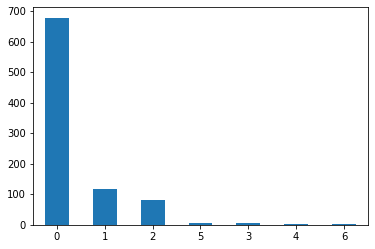

In [94]:
X.Parch.value_counts().plot.bar(rot=0);

Same as before, full numerical, no need to preprocess.

#### 8. Ticket

Ticket is a object type feature. It has many different values among the dataset (681). At this first stage won't help us.

In [95]:
X.Ticket.describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

#### 9. Fare

So Fare is a numerical feature, we've no missing values, so we're good to go.

**Note:** we can consider in the future, to normalize this column, so as to ensure all values live between 0 and 1. This is better for the model to look for patterns.

In [96]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [97]:
X.Fare.isna().sum()

0

#### 10. Cabin

Let's see this feature.

In [98]:
X.Cabin.describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

In [99]:
X.Cabin.isna().sum()/len(X)

0.7710437710437711

We have a lot of NaN values, almost 80%. This won't be of any help. We can drop the column

#### 11. Embarked

This feature indicates where the passenger boarded the Titanic. It has only two missing values in all the dataset, and has three unique values:
* C = Cherbourg
* Q = Queenstown
* S = Southampton

With this information we can one-hot-encode this feature, similar to what we did with `Pclass`.

Manage of the NaN values:
* Drop the two rows
* Fill with random value

Anyways this may not be so important for the model itself. We'll see.

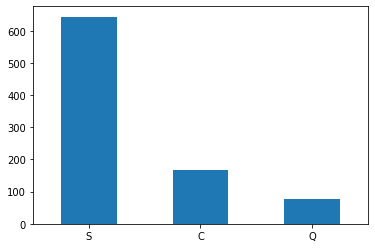

In [100]:
X.Embarked.value_counts().plot.bar(rot=0);

In [101]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Summing up

Columns we'll drop:
* PassengerId
* Survived
* Name
* Ticket
* Cabin

Features we'll preprocess:
* Pclass --> one-hot-encode
* Sex --> one-hot-encode
* Age --> fill NaN with median
* Embarked --> fill NaN with random value, one-hot-encode

Features we'll keep the same:
* SibSp
* Parch
* Fare

💡 **Investigate**: `pd.get_dummies` dummy_na --> Add a column to indicate NaNs, if False NaNs are ignored.

For the sake of clearness, we'll do everything in the following cells.

In [102]:
# Drop irrelevant columns
drop = ["PassengerId", "Survived", "Name", "Ticket", "Cabin"]
X = train.drop(drop, axis=1)

In [103]:
# Fillna Age column
X["Age"].fillna(X["Age"].median(), inplace=True)

In [104]:
# # Parse 'Name' column
# # Split words in name and make columns with the first and the rest of the split
# name = X.Name.str.split(",", 0, expand=True)
# # Drop the rest of the split
# name.drop(0, axis=1, inplace=True)
# # Parse spaces and save title
# name = name[1].str.replace(" ", "").str.split(".").str[0]
# # Replace this new column in X dataframe
# X["Name"] = name

In [105]:
# Fillna Embarked with random value
embarked = ["S", "C", "Q"]
X.Embarked.fillna(np.random.choice(embarked).astype(str), inplace=True)

In [106]:
# One-hot-encode
X = pd.get_dummies(X, columns=["Pclass", "Embarked", "Sex"])
X

Age  SibSp  Parch     Fare  ...  Embarked_Q  Embarked_S  Sex_female  Sex_male
0    22.0      1      0   7.2500  ...           0           1           0         1
1    38.0      1      0  71.2833  ...           0           0           1         0
2    26.0      0      0   7.9250  ...           0           1           1         0
3    35.0      1      0  53.1000  ...           0           1           1         0
4    35.0      0      0   8.0500  ...           0           1           0         1
..    ...    ...    ...      ...  ...         ...         ...         ...       ...
886  27.0      0      0  13.0000  ...           0           1           0         1
887  19.0      0      0  30.0000  ...           0           1           1         0
888  28.0      1      2  23.4500  ...           0           1           1         0
889  26.0      0      0  30.0000  ...           0           0           0         1
890  32.0      0      0   7.7500  ...           1           0           0         1

[891 rows x 12 columns]

In [107]:
# Define y set (truth labels)
y = train.Survived

Okey!!! We've finished getting the data ready. Remember that the test set must have the same format, so we'll need to do the same treatment to it. We'll do that now.

In [108]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [109]:
# Drop irrelevant columns
#test = test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
# Fillna Age column
test["Age"].fillna(test["Age"].median(), inplace=True)
# Fillna Fare column
test["Fare"].fillna(test["Fare"].median(), inplace=True)
# Fillna Embarked with random value
embarked = ["S", "C", "Q"]
test.Embarked.fillna(np.random.choice(embarked).astype(str), inplace=True)
# One-hot-encode
test = pd.get_dummies(test, columns=["Pclass", "Embarked", "Sex"])
test

PassengerId  ... Sex_male
0            892  ...        1
1            893  ...        0
2            894  ...        1
3            895  ...        1
4            896  ...        0
..           ...  ...      ...
413         1305  ...        1
414         1306  ...        0
415         1307  ...        1
416         1308  ...        1
417         1309  ...        1

[418 rows x 16 columns]

In [110]:
test.isna().sum()

PassengerId      0
Name             0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Pclass_1         0
Pclass_2         0
Pclass_3         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Sex_female       0
Sex_male         0
dtype: int64

### 2. Pick a model/estimator

Ok, let's remind ourselves what kind of problem are we attacking. This one is a **Classification** problem, ergo, we need Classification models.

There are a bunch of them, but if we use scikit-learn's [guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we can reduce our alternatives.

But for this trial, we'll compare:

1. LinearSVC
2. KNeighborsClassifier
3. SVC
4. LogisticRegression
5. RandomForestClassifier
6. CatBoostClassifier

#### CatBoost install
https://catboost.ai/en/docs/installation/python-installation-method-conda-install
    

### 3. Fitting a model and score (predict + evaluate)

We'll make a function to perform this actions on all the models

The steps we need to carry out for each model are:
* Instantiate model
* Fit model
* Score (predict + evaluate)
* Cross-validate (10 folds)
    * Accuracy
    * Precision
    * Recall
    * F1
* Time the process in all cases

In [111]:
# Instantiate all models in a dictionary
models = {
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
}

In order to fit the models, we need a train and test set. To acomplish that, we'll use scikit-learn's `train_test_split` function.

In [112]:
# Make train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((757, 12), (134, 12), (757,), (134,))

In [113]:
# Set random seed
np.random.seed(42)

# Fit and score models, save results in dictionary
results = {}
for model_name, model_instance in models.items():
    model_instance.fit(X_train, y_train)
    results[model_name] = np.round(model_instance.score(X_test, y_test), 4)
    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [114]:
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=["Accuracy"])
results_df

Accuracy
LinearSVC                 0.6269
KNN                       0.7612
SVC                       0.6567
LogisticRegression        0.8060
RandomForestClassifier    0.8284

In [ ]:
# Cross-validation with all metrics and all models
# Set random seed
np.random.seed(42)

scorings = ["accuracy", "recall", "precision", "f1"]
results_cv = {  
    "LinearSVC": {},
    "KNN": {},
    "SVC": {},
    "LogisticRegression": {},
    "RandomForestClassifier": {}}

for model_name, model_instance in models.items():
    for score in scorings:
        results_cv[model_name][score] = (np.mean(cross_val_score(model_instance, X, y, cv=10, scoring=score)))

In [116]:
results_df = pd.DataFrame(results_cv.values(), index=results_cv.keys(), columns=scorings)
results_df

accuracy    recall  precision        f1
LinearSVC               0.685680  0.695378   0.775687  0.613082
KNN                     0.715019  0.576134   0.646908  0.606289
SVC                     0.681323  0.301597   0.691197  0.415718
LogisticRegression      0.798002  0.698655   0.759211  0.724468
RandomForestClassifier  0.812659  0.725126   0.755084  0.745273

#### 6. CatBoostClassifier

CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

In [117]:
# View the data for the CatBoost model
X.head()

Age  SibSp  Parch     Fare  ...  Embarked_Q  Embarked_S  Sex_female  Sex_male
0  22.0      1      0   7.2500  ...           0           1           0         1
1  38.0      1      0  71.2833  ...           0           0           1         0
2  26.0      0      0   7.9250  ...           0           1           1         0
3  35.0      1      0  53.1000  ...           0           1           1         0
4  35.0      0      0   8.0500  ...           0           1           0         1

[5 rows x 12 columns]

In [118]:
# View the labels for the CatBoost model
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [138]:
# Define the categorical features for the CatBoost model
cat_features = np.squeeze(np.where(X.dtypes != np.float))
cat_features

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11])

In [140]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X, 
                  y,
                  cat_features=cat_features)

In [145]:
np.random.seed(42)

# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=False)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X, y) * 100, 2)

Learning rate set to 0.009807
0:	learn: 0.6870052	total: 5.27ms	remaining: 5.27s
1:	learn: 0.6802433	total: 17.6ms	remaining: 8.79s
2:	learn: 0.6739471	total: 26ms	remaining: 8.63s
3:	learn: 0.6689525	total: 36.1ms	remaining: 9s
4:	learn: 0.6623239	total: 44.8ms	remaining: 8.92s
5:	learn: 0.6572147	total: 59.9ms	remaining: 9.92s
6:	learn: 0.6515871	total: 65.3ms	remaining: 9.26s
7:	learn: 0.6457539	total: 73.9ms	remaining: 9.16s
8:	learn: 0.6409208	total: 82.2ms	remaining: 9.05s
9:	learn: 0.6363306	total: 85.7ms	remaining: 8.48s
10:	learn: 0.6315259	total: 87.3ms	remaining: 7.85s
11:	learn: 0.6273490	total: 91.4ms	remaining: 7.52s
12:	learn: 0.6222344	total: 94.5ms	remaining: 7.17s
13:	learn: 0.6176026	total: 98.9ms	remaining: 6.96s
14:	learn: 0.6133245	total: 102ms	remaining: 6.68s
15:	learn: 0.6091329	total: 105ms	remaining: 6.48s
16:	learn: 0.6045458	total: 112ms	remaining: 6.49s
17:	learn: 0.6003112	total: 117ms	remaining: 6.39s
18:	learn: 0.5954821	total: 126ms	remaining: 6.49s
19

In [146]:
np.random.seed(42)

# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
24:	learn: 0.4661878	test: 0.4400262	best: 0.4400262 (24)	total: 72.5ms	remaining: 2.83s
25:	learn: 0.4627295	test: 0.4367516	best: 0.4367516 (25)	total: 75.6ms	remaining: 2.83s
26:	learn: 0.4606288	test: 0.4336720	best: 0.4336720 (26)	total: 78.1ms	remaining: 2.81s
27:	learn: 0.4558556	test: 0.4293337	best: 0.4293337 (27)	total: 81.2ms	remaining: 2.82s
28:	learn: 0.4551616	test: 0.4288501	best: 0.4288501 (28)	total: 82.7ms	remaining: 2.77s
29:	learn: 0.4527089	test: 0.4258407	best: 0.4258407 (29)	total: 85.9ms	remaining: 2.78s
30:	learn: 0.4489453	test: 0.4212455	best: 0.4212455 (30)	total: 89ms	remaining: 2.78s
31:	learn: 0.4460821	test: 0.4184167	best: 0.4184167 (31)	total: 92.1ms	remaining: 2.79s
32:	learn: 0.4429271	test: 0.4154012	best: 0.4154012 (32)	total: 95.3ms	remaining: 2.79s
33:	learn: 0.4397808	test: 0.4122991	best: 0.4122991 (33)	total: 98.2ms	remaining: 2.79s
34:	learn: 0.4382604	test: 0.4104163	best: 0.4104163 (34)	tot

In [147]:
acc_catboost, acc_cv_catboost, catboost_time

(86.76, 82.72, 60.5739471912384)

**CatBoostClassfier** and **RandomForestClassifier** give the best results, so we'll continue with these models.

### 4. Hyperparameter tuning

For this instance, we're going to use GridSearchCV in order to get the best hyperparameters.

In [150]:
# Define hyperparameter dictionary for GridSearchCV
grid = {
    "n_estimators":[100, 500, 1000],
    "max_depth":[None, 5, 30],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

# Instantiate classifier
clf = RandomForestClassifier(n_jobs=-1)

# Setup GridSearchCV
gs_clf = GridSearchCV(clf, grid, scoring="f1", n_jobs=-1, cv=10, verbose=2)

# Fit train_data
gs_clf.fit(X_train, y_train)

# Score
gs_clf.score(X_test, y_test)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


0.7884615384615384

In [151]:
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

Refit with all dataset and `best_params`

In [160]:
clf = RandomForestClassifier(n_estimators=100,
                              max_depth=None,
                              max_features='auto',
                              min_samples_leaf=2,
                              min_samples_split=2)

In [161]:
clf.fit(X, y)

RandomForestClassifier(min_samples_leaf=2)

### 6. Submit predictions

In [162]:
X.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male'],
      dtype='object')

In [163]:
# Make predictions with best_params on wanted columns
predictions = clf.predict(test[X.columns])

In [164]:
# See predictions
predictions[:20]

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [165]:
len(predictions)

418

In [166]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [167]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('RFC_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!
